In [289]:
import torch 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [290]:
from sklearn.datasets import make_circles
n_samples = 1000

X,y = make_circles(n_samples,noise=0.03,random_state=42)

In [291]:
print(f"Isi X adalah:\n {X[:5]}")
print(f"Isi y adalah:\n {y[:5]}")

Isi X adalah:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
Isi y adalah:
 [1 1 1 1 0]


In [292]:
df = pd.DataFrame({"X1": X[:,0],"X2": X[:,1],"label":y})
df.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [293]:
df["label"].value_counts()

label
1    500
0    500
Name: count, dtype: int64

<Axes: xlabel='X1', ylabel='X2'>

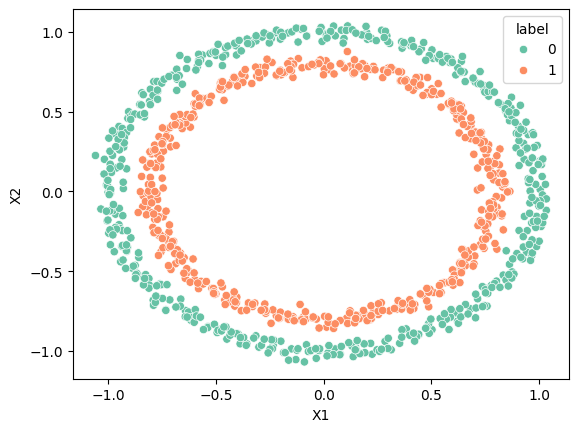

In [294]:
sns.scatterplot(x=df["X1"],y=df["X2"],data=df,hue="label",palette="Set2")

In [295]:
X = torch.tensor(df.drop("label", axis=1).values,dtype=torch.float)
y = torch.tensor(df["label"].values,dtype=torch.float)

In [296]:
type(X),X.dtype,y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [297]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


In [298]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [299]:
from torch import nn

class CircleModelV0(nn.Module):
    def __init__(self) :
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self,X):
       return self.layer_2(self.layer_1(X))

In [300]:
circle_model_v0 = CircleModelV0().to(device)
circle_model_v0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [301]:
class CircleModelV1(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.two_linear_layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=5),
            nn.Linear(in_features=5, out_features=1),
        )

    def forward(self,X):
        return self.two_linear_layers(X)

In [302]:
torch.manual_seed(42)
circle_model_v1 = CircleModelV1()
circle_model_v1

CircleModelV1(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [303]:
circle_model_v1.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [304]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=circle_model_v1.parameters(),lr=0.1)

In [305]:
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum()
    acc = correct / len(y_pred) * 100
    return torch.round(acc,decimals=5)

In [306]:
circle_model_v1.eval()
with torch.inference_mode():
    y_pred = circle_model_v1(X_test)

    print(f"Acc: {accuracy_fn(y_true=y_test, y_pred=y_pred.squeeze())}")

Acc: 0.0


In [307]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 200

for epoch in range(epochs):

    circle_model_v1.train()

    ## Logits -> Pred Probs -> Pred labels
    y_logits = circle_model_v1(X_train).squeeze()

    y_pred = torch.round(torch.sigmoid(y_logits)).squeeze()

    train_loss = loss_fn(y_logits,y_train)

    acc = accuracy_fn(y_train,y_pred)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    if epoch % 20 == 0:
        circle_model_v1.eval()
        with torch.inference_mode():
            y_logits_test = circle_model_v1(X_test).squeeze()
            y_pred_test = torch.round(torch.sigmoid(y_logits_test)).squeeze()
            test_acc = accuracy_fn(y_test,y_pred_test)

            print(
                f"Epoch: {epoch} | Train Loss: {train_loss:.5f} | Train Acc: {acc:} | Test Acc: {test_acc}"
            )

Epoch: 0 | Train Loss: 0.69569 | Train Acc: 50.0 | Test Acc: 50.0
Epoch: 20 | Train Loss: 0.69343 | Train Acc: 46.0 | Test Acc: 48.5
Epoch: 40 | Train Loss: 0.69312 | Train Acc: 49.5 | Test Acc: 46.5
Epoch: 60 | Train Loss: 0.69306 | Train Acc: 50.5 | Test Acc: 46.5
Epoch: 80 | Train Loss: 0.69304 | Train Acc: 50.75 | Test Acc: 46.5
Epoch: 100 | Train Loss: 0.69302 | Train Acc: 50.5 | Test Acc: 46.5
Epoch: 120 | Train Loss: 0.69301 | Train Acc: 50.625 | Test Acc: 45.5
Epoch: 140 | Train Loss: 0.69300 | Train Acc: 50.875 | Test Acc: 45.5
Epoch: 160 | Train Loss: 0.69300 | Train Acc: 51.0 | Test Acc: 46.0
Epoch: 180 | Train Loss: 0.69299 | Train Acc: 50.875 | Test Acc: 46.5


In [308]:
import requests
from pathlib import Path

url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py"

file_path = Path("../helper_functions.py")

if file_path.is_file():
    print("File Sudah ada")
else:
    print("Download helper function")
    response = requests.get(url)
    with open(file_path, "wb") as f:
        f.write(response.content)

File Sudah ada


In [309]:
import sys
sys.path.append(str(Path("helper_functions.py").resolve().parent.parent))

# Setelah parent path ditambahkan, kamu bisa mengimpor seperti biasa
from helper_functions import plot_decision_boundary

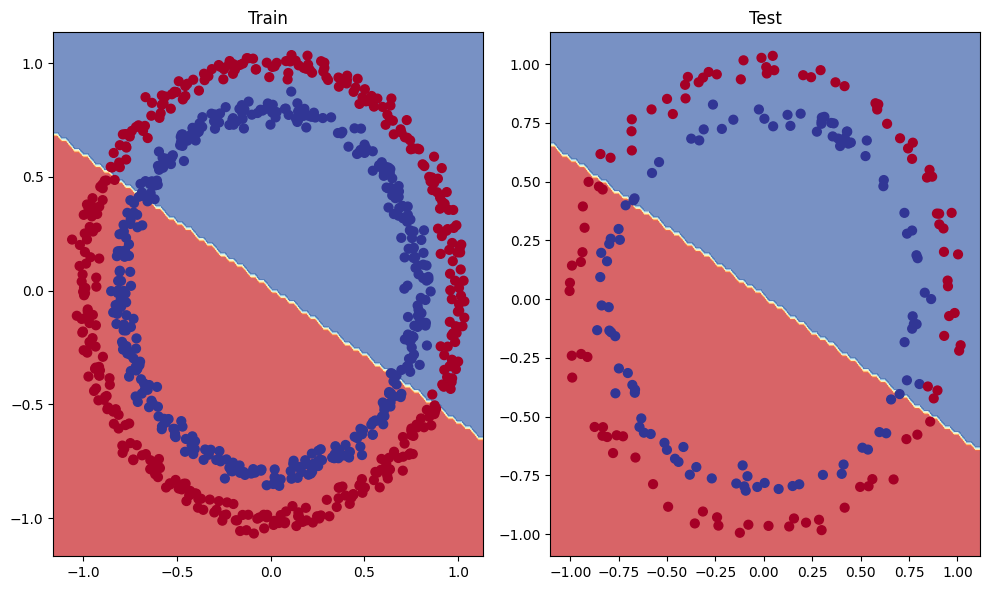

In [310]:
fig,axes = plt.subplots(1,2,figsize=(10,6))

plt.sca(axes[0])
axes[0].set_title("Train")
plot_decision_boundary(circle_model_v1,X_train,y_train)

plt.sca(axes[1])
axes[1].set_title("Test")
plot_decision_boundary(circle_model_v1, X_test, y_test)

fig.tight_layout()

### UNDERFITINGGGG

In [311]:
class CircleModelV2(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=1),

        )
    def forward(self,X):
        return self.layers(X)

In [312]:
torch.manual_seed(42)
circle_model_v2 = CircleModelV2()

In [313]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=circle_model_v2.parameters(),lr=0.1)

In [314]:
circle_model_v2.to(device)

CircleModelV2(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [315]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 100
train__error =  []
test__error = []
epoch_values = []

for epoch in range(epochs + 1):
    circle_model_v2.train()

    train_logits = circle_model_v2(X_train).squeeze()
    y_pred_train = torch.round(torch.sigmoid(train_logits))

    train_loss = loss_fn(train_logits,y_train)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    if epoch % 10 == 0:
        epoch_values.append(epoch)
        train__error.append(train_loss)

        circle_model_v2.eval()
        with torch.inference_mode():
            test_logits = circle_model_v2(X_test).squeeze()
            y_pred_test = torch.round(torch.sigmoid(test_logits))

            test_loss = loss_fn(test_logits,y_test)
            test__error.append(test_loss)

            print(f"Epoch: {epoch} | Train error: {train_loss:.4f} | Train acc: {accuracy_fn(y_train,y_pred_train)} | Train loss: {train_loss:.4f} | Test acc: {accuracy_fn(y_test,y_pred_test)}")

Epoch: 0 | Train error: 0.6929 | Train acc: 50.0 | Train loss: 0.6929 | Test acc: 50.0
Epoch: 10 | Train error: 0.5828 | Train acc: 69.0 | Train loss: 0.5828 | Test acc: 75.0
Epoch: 20 | Train error: 0.2035 | Train acc: 99.375 | Train loss: 0.2035 | Test acc: 97.5
Epoch: 30 | Train error: 0.0364 | Train acc: 99.5 | Train loss: 0.0364 | Test acc: 98.49999237060547
Epoch: 40 | Train error: 0.0116 | Train acc: 100.0 | Train loss: 0.0116 | Test acc: 99.5
Epoch: 50 | Train error: 0.0058 | Train acc: 100.0 | Train loss: 0.0058 | Test acc: 98.99999237060547
Epoch: 60 | Train error: 0.0036 | Train acc: 100.0 | Train loss: 0.0036 | Test acc: 99.5
Epoch: 70 | Train error: 0.0027 | Train acc: 100.0 | Train loss: 0.0027 | Test acc: 100.0
Epoch: 80 | Train error: 0.0022 | Train acc: 100.0 | Train loss: 0.0022 | Test acc: 100.0
Epoch: 90 | Train error: 0.0019 | Train acc: 100.0 | Train loss: 0.0019 | Test acc: 100.0
Epoch: 100 | Train error: 0.0017 | Train acc: 100.0 | Train loss: 0.0017 | Test acc:

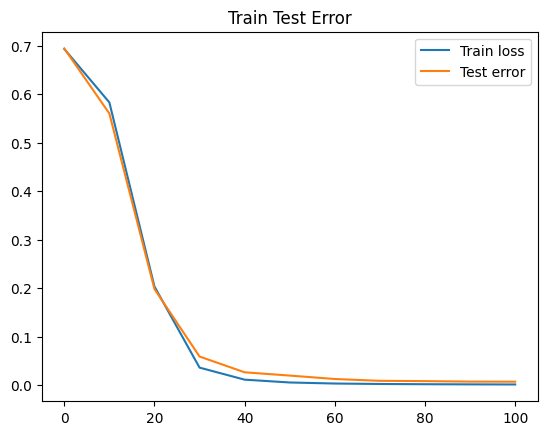

In [316]:
plt.title("Train Test Error")
plt.plot(torch.tensor(epoch_values).cpu(),torch.tensor(train__error).cpu(),label="Train loss")

plt.plot(torch.tensor(epoch_values).cpu(), torch.tensor(test__error).cpu(),label="Test error")

plt.legend()

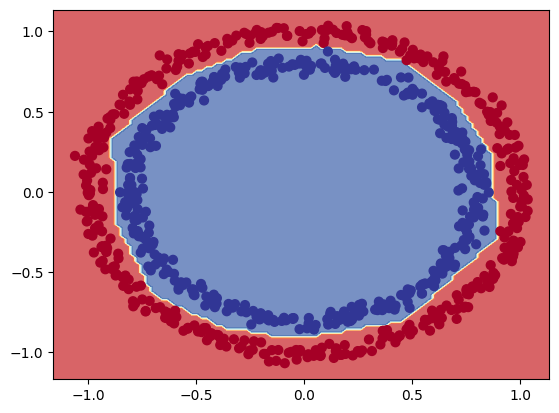

In [317]:
plot_decision_boundary(circle_model_v2,X_train,y_train)